# DMML Assignment 2

submission by: Utpalraj Kemprai(DS1) and Sayan Bose(CS1)

In [1]:
# import necessary libraries
import numpy as np
from time import time
import tqdm

In [2]:
# function for loading the data
from scipy.sparse import csr_matrix


def load_data(docword_path):
    with open(docword_path, "r") as f:
        D, W, NNZ = [int(next(f)) for _ in range(3)]
        rows, cols = [], []
        for line in f:
            docID, wordID, _ = map(int, line.split())
            cols.append(wordID - 1)
            rows.append(docID - 1)
        data = np.ones(len(rows))
        doc = csr_matrix((data, (rows, cols)), shape=(D, W))
    return doc

In [3]:
from sklearn.utils import check_random_state
from joblib import Parallel, delayed


# function to calculate Jaccard distance between two points
def jaccard_distance(x, y):
    if isinstance(x, csr_matrix) and isinstance(y, csr_matrix):
        inter = x.dot(y.transpose()).max()
        union = x.sum() + y.sum() - inter
    elif isinstance(x, csr_matrix) and isinstance(y, np.ndarray):
        inter = sum(x.dot(y.T))
        union = x.sum() + y.sum() - inter
    else:
        inter = np.dot(x, y)
        union = sum(x) + sum(y) - inter
    return 1 - inter / union


# Parallel computation of distances between data points and cluster centers
def compute_distances(X, center):
    distances = [jaccard_distance(X[i], center) for i in range(X.shape[0])]
    return distances


# implementation of kmeans using Jaccard distance
def kmeans_jaccard(X, k, max_iter=30, random_state=None, tol=0, n_jobs=-1):
    random_state = check_random_state(random_state)
    centers = X[random_state.choice(X.shape[0], k, replace=False)].toarray()
    labels = np.zeros(X.shape[0], dtype=int)
    for it in range(max_iter):
        # Parallel computation of distances
        distance_list = Parallel(n_jobs=n_jobs)(
            delayed(compute_distances)(X, centers[j]) for j in range(k)
        )
        distances = np.array(distance_list).T

        # Update labels
        labels = np.argmin(distances, axis=1)

        # # Update centers parallely
        # new_centers = Parallel(n_jobs=n_jobs)(
        #     delayed(np.mean)(X[labels == i], axis=0) for i in range(k)
        # )

        # Update centers
        new_centers = np.zeros(centers.shape)
        for i in range(k):
            mask = labels == i
            new_centers[i] = X[mask].mean(axis=0)
        if not tol:
            if np.all(new_centers == centers):
                break
            centers = new_centers
        else:
            if (
                np.mean(
                    [jaccard_distance(centers[i], new_centers[i]) for i in range(k)]
                )
                <= tol
            ):  # can be updated
                break
            centers = new_centers
    return labels, centers

In [5]:
import matplotlib.pyplot as plt


# function for plotting sum of square jaccard distances between
# points and centers of their clusters
def plot_ssd(X, max_k=10, max_iter=30, tol=0, random_state=None):
    ssd = []
    for k in tqdm.tqdm(range(1, max_k + 1)):
        ssd_k = 0
        labels, centers = kmeans_jaccard(
            X, k, max_iter=max_iter, random_state=random_state, tol=tol
        )
        for i in range(X.shape[0]):
            distances = jaccard_distance(X[i], centers[labels[i]])
            ssd_k += distances * distances
        ssd.append(ssd_k)
    # Find elbow point

    plt.plot(range(1, max_k + 1), ssd, "o-")
    plt.xlabel("k")
    plt.ylabel("Sum of squared distances")
    plt.title("Elbow Method For Optimal k")
    plt.show()

## Clustering for the kos dataset

KOS blog entries:
orig source: dailykos.com

	  D=3430
	  W=6906
	  N=467714
	

Reading the data

In [6]:
start = time()
kos_doc = load_data("docword.kos.txt")
end = time()
print("Time needed: ", end - start)

Time needed:  0.2191023826599121


In [7]:
kos_doc.shape

(3430, 6906)

sparsity of the kos documents

In [8]:
print("Sparsity for KOS docs ")
1 - kos_doc.sum() / (kos_doc.shape[0] * kos_doc.shape[1])

Sparsity for KOS docs 


0.9850909210649632

Find optimal k using elbow method

100%|██████████| 20/20 [05:49<00:00, 17.47s/it]


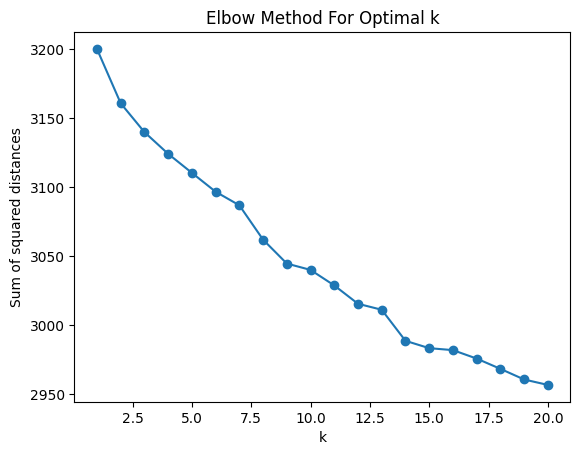

Time needed:  349.4988660812378


In [9]:
start = time()
plot_ssd(kos_doc, max_iter=100, max_k=20, random_state=42)
end = time()
print("Time needed: ", end - start)

## Clustering for the NIPS dataset

NIPS full papers:
orig source: books.nips.cc

	  D=1500
	  W=12419
	  N=1,900,000 (approx)
	

Reading the data

In [10]:
start = time()
nips_doc = load_data("docword.nips.txt")
end = time()
print("Time needed: ", end - start)

Time needed:  0.3965139389038086


In [11]:
nips_doc.shape

(1500, 12419)

sparsity of NIPS documents

In [12]:
print("Sparsity for NIPS docs ")
1 - nips_doc.sum() / (nips_doc.shape[0] * nips_doc.shape[1])

Sparsity for NIPS docs 


0.9599368709235848

Find optimal k using elbow method

100%|██████████| 20/20 [01:49<00:00,  5.47s/it]


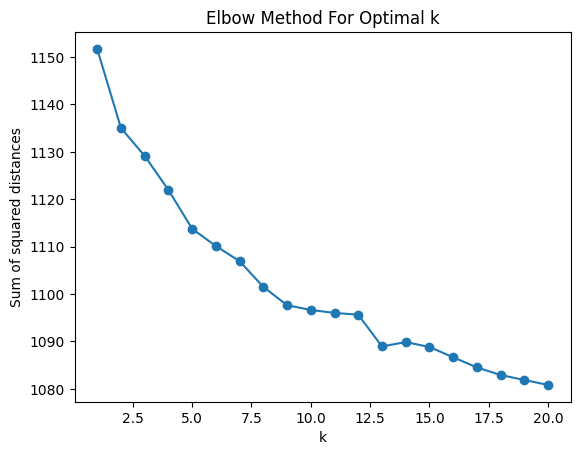

In [13]:
start = time()
plot_ssd(nips_doc, max_iter=100, max_k=20, random_state=42)
end = time()
print("Time needed: ", end - start)

## Clustering for the ENRON dataset

Enron Emails:
orig source: www.cs.cmu.edu/~enron

	  D=39861
	  W=28102
	  N=6,400,000 (approx)
	

Reading the data

In [14]:
start = time()
enron_doc = load_data("docword.enron.txt")
end = time()
print("Time needed: ", end - start)

Time needed:  2.010629653930664


In [15]:
enron_doc.shape

(39861, 28102)

sparsity of ENRON docs

In [16]:
print("Sparsity for ENRON docs ")
1 - enron_doc.sum() / (enron_doc.shape[0] * enron_doc.shape[1])

Sparsity for ENRON docs 


0.996687639072501

Find optimal k using elbow method

100%|██████████| 12/12 [58:02<00:00, 290.22s/it]


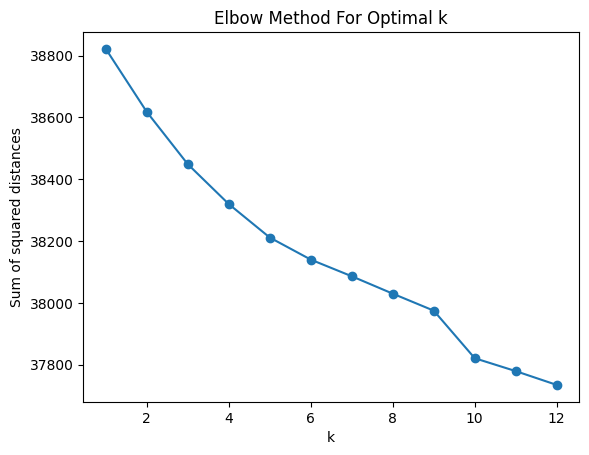

Time needed:  3482.7250080108643


In [22]:
start = time()
plot_ssd(enron_doc, max_iter=50, max_k=12, random_state=42, tol=0.01)
end = time()
print("Time needed: ", end - start)